In [1]:
from kaggle_secrets import UserSecretsClient
secret_label = "Token"
token = UserSecretsClient().get_secret(secret_label)

! git clone https://{token}@github.com/CarloSgaravatti/Recsys_Challenge_2023.git

Cloning into 'Recsys_Challenge_2023'...
remote: Enumerating objects: 6425, done.
remote: Counting objects: 100% (1614/1614), done.
remote: Compressing objects: 100% (294/294), done.
remote: Total 6425 (delta 1389), reused 1521 (delta 1311), pack-reused 4811
Receiving objects: 100% (6425/6425), 2.95 GiB | 22.34 MiB/s, done.
Resolving deltas: 100% (5215/5215), done.
Updating files: 100% (511/511), done.


In [2]:
! pip install PyGithub requests

  Obtaining dependency information for PyGithub from https://files.pythonhosted.org/packages/be/04/810d131be173cba445d3658a45512b2b2b3d0960d52c4a300d6ec5e00f52/PyGithub-2.1.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.9/302.9 kB 16.8 MB/s eta 0:00:00


In [3]:
! pip install implicit

  Obtaining dependency information for implicit from https://files.pythonhosted.org/packages/cd/cc/deac70cae8cc32c9885d0cd73bc66e1b3cbea36ae7080b8c83995eaf5322/implicit-0.7.2-cp310-cp310-manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 25.8 MB/s eta 0:00:00


In [4]:
! cd /kaggle/working/Recsys_Challenge_2023 && python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorization_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1940,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from MatrixFactorization_Cython_Epoch.c:1109:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorization_Cython_Epoch.c: In function ‘__pyx_pf_32MatrixFactorization

In [5]:
import numpy as np
from numpy import linalg as LA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
import random
import tqdm
import gc
import time
import os
import shutil
import optuna
import scipy.sparse as sps
import scipy.stats as stats
from concurrent.futures import ThreadPoolExecutor

from lightgbm import LGBMClassifier

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv
/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv
/kaggle/input/training-tuned-models/als_all.npz
/kaggle/input/training-tuned-models/__results__.html
/kaggle/input/training-tuned-models/ease_r_all.zip
/kaggle/input/training-tuned-models/mult_vae_2_train_validation.zip
/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz
/kaggle/input/training-tuned-models/als_train_validation.npz
/kaggle/input/training-tuned-models/mult_vae_2_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/slim_recall_train_validation.zip
/kaggle/input/training-tuned-models/ease_r_train_validation.zip
/kaggle/input/training-tuned-models/__notebook__.ipynb
/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip
/kaggle/input/training-tuned-models/ials_train_validation.zip
/kaggle/input/training-tuned-models/mult_vae_2_all.zip
/kaggle/input/training-tuned-models/ease_r_xgbo

In [6]:
%cd /kaggle/working/Recsys_Challenge_2023

/kaggle/working/Recsys_Challenge_2023


In [7]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Recommenders.SLIM.SLIMElasticNetRecommender import MultiThreadSLIM_SLIMElasticNetRecommender, SLIMElasticNetRecommender
from Evaluation.Evaluator import EvaluatorHoldout
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender, PureSVDItemRecommender, ScaledPureSVDRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNSimilarityHybridRecommender import ItemKNNSimilarityHybridRecommender
from Recommenders.KNN.ItemKNNCustomSimilarityRecommender import ItemKNNCustomSimilarityRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.BaseRecommender import BaseRecommender
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.SLIM.SLIM_BPR_Python import SLIM_BPR_Python
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender
from Recommenders.Neural.MultVAERecommender import MultVAERecommender

from Recommenders.Hybrid.LinearCombinationRecommender import LinearCombinationRecommender
from Data_manager.CrossValidationSplitter import CrossValidationSplitter
from Recommenders.MatrixFactorization.ALSImplicitRecommender import ALSImplicitRecommender
from Recommenders.GraphBased.HHPRecommender import HHPRecommender
from Recommenders.GraphBased.TwoWayRankAggregationRecommender import TwoWayRankAggregationRecommender

np.int = int
np.random.seed(42)
np.bool = bool
np.float = float

In [8]:
from github import Github
from github import Auth

auth = Auth.Token(token)
g = Github(auth=auth)

repo = None
for r in g.get_user().get_repos():
    if r.name == 'Recsys_Challenge_2023':
        repo = r
        print('Repository found')

Repository found


In [9]:
def upload_file(filepath_kaggle, filepath_github, commit_message):
    try:
        contents = repo.get_contents(filepath_github)
        with open(filepath_kaggle, "rb") as file:
            repo.update_file(contents.path, commit_message, file.read(), contents.sha)
    except Exception:
        with open(filepath_kaggle, "rb") as file:
            repo.create_file(filepath_github, commit_message, file.read())

In [10]:
config = {
    'tune_parameters': True,
    'n_trials': 25,
    'database_path': '/kaggle/working/tuning_hybrid_xgboost.db',
    'copy_prev_tuning_db': True,
    'copy_prev_best_params': True,
    'save_github': True
}

In [11]:
train_data = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_train.csv')
user_ids_test = pd.read_csv('/kaggle/input/recommender-system-2023-challenge-polimi/data_target_users_test.csv')

In [12]:
URM_all = sps.csr_matrix((train_data.data.values,
                          ((train_data.row - 1).values, (train_data.col - 1).values)),
                        shape=(train_data.row.max(), train_data.col.max()))
URM_all

<13024x22347 sparse matrix of type '<class 'numpy.float64'>'
	with 478730 stored elements in Compressed Sparse Row format>

In [13]:
URM_train_complete, URM_test_complete = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_complete, train_percentage = 0.8)

In [14]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_item.json', 'r') as params_file:
    params_item_knn = json.load(params_file)
params_item_knn

{'topK': 14,
 'shrink': 25,
 'similarity': 'tversky',
 'tversky_alpha': 0.18163095712123836,
 'tversky_beta': 1.8529812241698465}

In [15]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_RP3.json', 'r') as params_file:
    params_rp3 = json.load(params_file)
params_rp3

{'alpha': 0.3408516511081212, 'beta': 0.1447198697205665, 'topK': 32}

In [16]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_knn_user.json', 'r') as params_file:
    params_user_knn = json.load(params_file)
params_user_knn

{'topK': 498,
 'shrink': 0,
 'similarity': 'asymmetric',
 'asymmetric_alpha': 0.39792525383867455}

In [17]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_alpha.json', 'r') as params_file:
    params_p3alpha = json.load(params_file)
params_p3alpha

{'normalize_similarity': 'True',
 'implicit': 'True',
 'alpha': 0.29354071531607107,
 'topK': 49}

In [18]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_merging.json', 'r') as params_file:
    params_merging = json.load(params_file)
params_merging

{'alpha': 0.3375591188839621, 'topK': 86}

In [19]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hybrid_lr_comb_rp3_p3a_item.json', 'r') as params_file:
    params_lr_comb = json.load(params_file)
params_lr_comb

{'w1': 0.6982294749234325, 'w2': 0.9336649353144076, 'w3': 0.8685182329823133}

In [20]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/pure_svd_params.json', 'r') as params_file:
    params_pure_svd = json.load(params_file)
params_pure_svd

{'factors': 30}

In [21]:
# with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_item.json', 'r') as params_file:
#     params_pure_svd_item = json.load(params_file)
params_pure_svd_item = {"topK": 43, "num_factors": 171}

In [22]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_puresvd_scaled.json', 'r') as params_file:
    params_scaled = json.load(params_file)
params_scaled

{'num_factors': 179,
 'scaling_items': 5.3298425368534826e-05,
 'scaling_users': 0.2791990262721904}

In [23]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_hhp.json', 'r') as params_file:
    params_hhp = json.load(params_file)
params_hhp

{'hybrid_lambda': 0.8450256587797654, 'topK': 61}

In [24]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_twra.json', 'r') as params_file:
    params = json.load(params_file)

params_twra = {
    'base_f_algorithm': params['base_f_algorithm'], 
    'base_b_algorithm': params['base_b_algorithm'], 
    'convex_lambda': params['convex_lambda'],
}

if params['base_f_algorithm'] == 'p3':
    params_twra['f_params'] = {
        'topK': params['f_p3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_f_algorithm'] == 'p3alpha':
    params_twra['f_params'] = {
        'alpha': params['f_p3a_alpha'],
        'topK': params['f_p3a_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_f_algorithm'] == 'rp3beta':
    params_twra['f_params'] = {
        'alpha': params['f_rp3_alpha'],
        'beta': params['f_rp3_beta'],
        'topK': params['f_rp3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
else:
    params_twra['f_params'] = {
        'hybrid_lambda': params['f_hhp_hybrid_lambda'],
        'topK': params['f_hhp_topK'],
    }

if params['base_b_algorithm'] == 'p3':
    params_twra['b_params'] = {
        'topK': params['b_p3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_b_algorithm'] == 'p3alpha':
    params_twra['b_params'] = {
        'alpha': params['b_p3a_alpha'],
        'topK': params['b_p3a_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
elif params['base_b_algorithm'] == 'rp3beta':
    params_twra['b_params'] = {
        'alpha': params['b_rp3_alpha'],
        'beta': params['b_rp3_beta'],
        'topK': params['b_rp3_topK'],
        'implicit': True, 
        'normalize_similarity': True
    }
else:
    params_twra['b_params'] = {
        'hybrid_lambda': params['b_hhp_hybrid_lambda'],
        'topK': params['b_hhp_topK'],
    }

In [25]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_rp3_recall@50.json', 'r') as params_file:
    params_rp3_recall = json.load(params_file)
params_rp3_recall

{'alpha': 0.2139985499567939, 'beta': 0.2194371742883361, 'topK': 154}

In [26]:
with open('/kaggle/working/Recsys_Challenge_2023/tuning_results/best_params_item_knn_recall@50.json', 'r') as params_file:
    params_item_knn_recall = json.load(params_file)
params_item_knn_recall

{'topK': 62,
 'shrink': 480,
 'similarity': 'tversky',
 'feature_weighting': 'BM25',
 'tversky_alpha': 0.03679620043176055,
 'tversky_beta': 1.9314395554791928}

In [27]:
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_xgboost_train_validation.zip', 
    '/kaggle/working/ials_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_train_validation.zip', 
    '/kaggle/working/ials_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/ials_all.zip', 
    '/kaggle/working/ials_all.zip', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_xgboost_train_validation.npz', 
    '/kaggle/working/als_xgboost_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_train_validation.npz', 
    '/kaggle/working/als_train_validation.npz', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/als_all.npz', 
    '/kaggle/working/als_all.npz', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_xgboost_train_validation.zip', 
    '/kaggle/working/slim_recall_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_train_validation.zip', 
    '/kaggle/working/slim_recall_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/slim_recall_all.zip', 
    '/kaggle/working/slim_recall_all.zip', 
)

shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_xgboost_train_validation.zip', 
    '/kaggle/working/mult_vae_2_xgboost_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_train_validation.zip', 
    '/kaggle/working/mult_vae_2_train_validation.zip', 
)
shutil.copyfile(
    '/kaggle/input/training-tuned-models/mult_vae_2_all.zip', 
    '/kaggle/working/mult_vae_2_all.zip', 
)

'/kaggle/working/mult_vae_2_all.zip'

In [28]:
recommender_item = ItemKNNCFRecommender(URM_train)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_train = recommender_pure_svd.USER_factors
item_factors_train = recommender_pure_svd.ITEM_factors

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train)
recommender_scaled_svd.fit(**params_scaled)

recommender_pure_svd_item = PureSVDItemRecommender(URM_train)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_xgboost_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_xgboost_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_xgboost_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_xgboost_train_validation.zip')

recommender_ials = IALSRecommender(URM_train)
recommender_ials.load_model('/kaggle/working/', 'ials_xgboost_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_xgboost_train_validation')

recommender_hhp = HHPRecommender(URM_train)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_train)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_train)
# recommender_als.load_model('/kaggle/working/', 'als_xgboost_train_validation.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_train)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_xgboost_train_validation.zip')

recommender_rp3_recall = RP3betaRecommender(URM_train)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_train)
recommender_item_recall.fit(**params_item_knn_recall)

ItemKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
ItemKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Similarity column 22347 (100.0%), 4539.78 column/sec. Elapsed time 4.92 sec
UserKNNCFRecommender: URM Detected 851 ( 6.5%) users with no interactions.
UserKNNCFRecommender: URM Detected 476 ( 2.1%) items with no interactions.
Similarity column 13024 (100.0%), 4916.95 column/sec. Elapsed time 2.65 sec
RP3betaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
RP3betaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2628.37 column/sec. Elapsed time 8.50 sec
P3alphaRecommender: URM Detected 851 ( 6.5%) users with no interactions.
P3alphaRecommender: URM Detected 476 ( 2.1%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 3222.03 column/sec. Elapsed time 6.94 sec
PureSVDRecommender: URM Detected 851 ( 6.5%) users with no inter

In [29]:
evaluator = EvaluatorHoldout(URM_test_complete, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2568 (19.7%) Users that have less than 1 test interactions


In [30]:
cutoff = 50
n_users, n_items = URM_train.shape

training_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
training_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    if user_id == 0:
        print(recommendations)
    training_dataframe.loc[user_id, "ItemID"] = recommendations
    
training_dataframe = training_dataframe.explode("ItemID")
training_dataframe

/tmp/ipykernel_20/2461008040.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for user_id in tqdm.tqdm_notebook(range(n_users)):


  0%|          | 0/13024 [00:00<?, ?it/s]

[   0    1    2    3    9   28   35   53   57   75   76   84   86   97
  100  101  111  122  136  138  155  170  215  253  256  260  283  288
  336  341  366  402  428  429  505  514  533  591  617  634  636  693
  715  772  849  868  921  976 1056 1067 1082 1088 1131 1213 1222 1287
 1337 1421 1480 1489 1515 1545 1629 1744 1934 2002 2011 2498 2667 2781
 3156 3315 3728 6222 8455 8500]


,ItemID
UserID,
0,0
0,1
0,2
0,3
0,9
...,...
13023,11653
13023,11827
13023,11955


In [31]:
URM_validation_coo = sps.coo_matrix(URM_validation)

correct_recommendations = pd.DataFrame({"UserID": URM_validation_coo.row,
                                        "ItemID": URM_validation_coo.col})
correct_recommendations

,UserID,ItemID
0,0,15
1,0,385
2,0,1934
3,0,4302
4,0,17444
...,...,...
76592,13023,2365
76593,13023,2961
76594,13023,3606
76595,13023,6282


In [32]:
training_dataframe = pd.merge(training_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
training_dataframe["Label"] = training_dataframe["Exist"] == "both"
training_dataframe.drop(columns = ['Exist'], inplace=True)
training_dataframe

,UserID,ItemID,Label
0,0,0,False
1,0,1,False
2,0,2,False
3,0,3,False
4,0,9,False
...,...,...,...
1067012,13023,11653,False
1067013,13023,11827,False
1067014,13023,11955,False
1067015,13023,13592,False


In [33]:
training_dataframe.Label.sum()

19954

In [34]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [35]:
training_dataframe = training_dataframe.set_index('UserID')

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = training_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        training_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        training_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        training_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()

item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        training_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[training_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        training_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        training_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        training_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        training_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        training_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[training_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        training_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        training_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        training_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        training_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        training_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        training_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

# todo: cluster if possible the similarity matrix of KNN or RP3, then add for each users some features 
# that represent something like users that like only items from the same cluster (e.g. items variability)
# same can be done with users and items reversed (i.e. using User KNN)

recommended_columns = [col for col in training_dataframe.columns if col.endswith('_Recommended')]
training_dataframe['Counter_Recommended'] = training_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in training_dataframe.columns if col.endswith('_RankPosition')]
training_dataframe['Mean_RankPosition'] = training_dataframe[position_columns].mean(axis=1)
training_dataframe['Std_RankPosition'] = training_dataframe[position_columns].std(axis=1)
training_dataframe['Skew_RankPosition'] = training_dataframe[position_columns].skew(axis=1)
training_dataframe['Kurtosis_RankPosition'] = training_dataframe[position_columns].kurtosis(axis=1)

# todo: weighted score makes sense? Same features of position but for score might be not useful
# since ranges are different

training_dataframe = training_dataframe.reset_index()
training_dataframe = training_dataframe.rename(columns = {"index": "UserID"})
training_dataframe

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_20/2167912425.py:39: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  training_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
/tmp/ipykernel_20/2167912425.py:40: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  training_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)


  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,MaxSimilarityToSeenRP3,MinSimilarityToSeenRP3,StdSimilarityToSeenRP3,SkewSimilarityToSeenRP3,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition
0,0,0,False,0.000000,21981.0,0.0,0.002247,239.0,0.0,0.172726,...,0.000000,0.0,0.000000,NaN,NaN,0,4445.666667,8529.421205,1.690904,1.091150
1,0,1,False,0.000000,7492.0,0.0,0.002246,240.0,0.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,0,4343.000000,4470.049600,0.489168,-1.226420
2,0,2,False,0.000000,7493.0,0.0,0.005024,181.0,0.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,1,5105.333333,6395.478421,1.250119,1.349319
3,0,3,False,0.000000,7494.0,0.0,0.003501,190.0,0.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,0,3841.733333,4173.833344,0.298786,-1.885747
4,0,9,False,0.000000,7499.0,0.0,0.004615,183.0,0.0,0.000000,...,0.000000,0.0,0.000000,NaN,NaN,0,3788.000000,4224.468792,0.373077,-1.696020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067012,13023,11653,False,0.176484,17.0,0.0,0.124148,146.0,0.0,0.176945,...,0.065990,0.0,0.011571,4.329403,18.561111,0,116.933333,114.431805,0.992899,-0.336770
1067013,13023,11827,False,0.039908,156.0,0.0,0.102497,217.0,0.0,0.000000,...,0.024023,0.0,0.003503,6.559135,41.022263,0,4422.266667,7480.642309,1.583376,0.719424
1067014,13023,11955,False,0.092565,54.0,0.0,0.111171,184.0,0.0,0.077925,...,0.040833,0.0,0.008920,3.700808,12.059912,0,421.600000,570.533309,2.327301,5.760052
1067015,13023,13592,False,0.295934,5.0,1.0,0.102905,214.0,0.0,0.233513,...,0.080118,0.0,0.016885,2.835449,7.682983,5,283.400000,365.269138,1.096526,-0.394693


In [36]:
item_popularity = np.ediff1d(sps.csc_matrix(URM_train).indptr)
item_popularity = item_popularity / np.max(item_popularity)
training_dataframe['item_popularity'] = item_popularity[training_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train).indptr)
user_popularity = user_popularity / np.max(user_popularity)
training_dataframe['user_profile_len'] = user_popularity[training_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
training_dataframe['mainstream_user'] = mainstream_user[training_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
training_dataframe['mainstream_item'] = mainstream_item[training_dataframe["ItemID"].values.astype(int)]
training_dataframe

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition,item_popularity,user_profile_len,mainstream_user,mainstream_item
0,0,0,False,0.000000,21981.0,0.0,0.002247,239.0,0.0,0.172726,...,NaN,0,4445.666667,8529.421205,1.690904,1.091150,0.886424,0.033573,77.384713,64.370937
1,0,1,False,0.000000,7492.0,0.0,0.002246,240.0,0.0,0.000000,...,NaN,0,4343.000000,4470.049600,0.489168,-1.226420,1.000000,0.033573,77.384713,62.304556
2,0,2,False,0.000000,7493.0,0.0,0.005024,181.0,0.0,0.000000,...,NaN,1,5105.333333,6395.478421,1.250119,1.349319,0.816327,0.033573,77.384713,66.387950
3,0,3,False,0.000000,7494.0,0.0,0.003501,190.0,0.0,0.000000,...,NaN,0,3841.733333,4173.833344,0.298786,-1.885747,0.988465,0.033573,77.384713,68.811732
4,0,9,False,0.000000,7499.0,0.0,0.004615,183.0,0.0,0.000000,...,NaN,0,3788.000000,4224.468792,0.373077,-1.696020,0.507542,0.033573,77.384713,58.666614
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1067012,13023,11653,False,0.176484,17.0,0.0,0.124148,146.0,0.0,0.176945,...,18.561111,0,116.933333,114.431805,0.992899,-0.336770,0.007986,0.055156,53.265190,302.245004
1067013,13023,11827,False,0.039908,156.0,0.0,0.102497,217.0,0.0,0.000000,...,41.022263,0,4422.266667,7480.642309,1.583376,0.719424,0.006211,0.055156,53.265190,326.633094
1067014,13023,11955,False,0.092565,54.0,0.0,0.111171,184.0,0.0,0.077925,...,12.059912,0,421.600000,570.533309,2.327301,5.760052,0.005324,0.055156,53.265190,211.481415
1067015,13023,13592,False,0.295934,5.0,1.0,0.102905,214.0,0.0,0.233513,...,7.682983,5,283.400000,365.269138,1.096526,-0.394693,0.004437,0.055156,53.265190,296.209113


In [37]:
user_factors_df = pd.DataFrame(user_factors_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_train[:, :5].shape[1])])

training_dataframe = training_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
training_dataframe = training_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
training_dataframe = training_dataframe.sort_values(by='UserID')
training_dataframe

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,False,0.000000,21981.0,0.0,0.002247,239.0,0.0,0.172726,...,0.163921,0.090707,-0.216788,-0.041741,0.056197,0.005684,-0.001896,0.008995,-0.013853,-0.002147
54,0,1222,False,0.000000,7796.0,0.0,0.000932,503.0,0.0,0.000000,...,0.008628,0.004001,0.018486,-0.012392,0.001480,0.005684,-0.001896,0.008995,-0.013853,-0.002147
53,0,1213,False,0.215692,16.0,0.0,0.069173,45.0,0.0,0.119938,...,0.007796,-0.009614,0.002953,-0.000483,-0.004862,0.005684,-0.001896,0.008995,-0.013853,-0.002147
52,0,1131,False,0.170961,21.0,0.0,0.000908,520.0,0.0,0.079453,...,0.008328,-0.008771,0.024645,0.012543,0.037796,0.005684,-0.001896,0.008995,-0.013853,-0.002147
51,0,1088,False,0.211910,17.0,0.0,0.000463,1199.0,0.0,0.095478,...,0.011467,-0.011217,0.021460,0.020043,0.052159,0.005684,-0.001896,0.008995,-0.013853,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066973,13023,695,False,0.051093,114.0,0.0,0.344100,10.0,0.0,0.000000,...,0.011910,-0.020622,0.017123,0.012590,0.042566,0.006896,-0.007143,0.001571,0.006195,0.023549
1066971,13023,605,True,0.057563,100.0,0.0,0.203670,56.0,0.0,0.061681,...,0.016095,-0.028862,0.009837,0.013453,0.047040,0.006896,-0.007143,0.001571,0.006195,0.023549
1066968,13023,407,False,0.000000,7195.0,0.0,0.277303,23.0,0.0,0.000000,...,0.019528,-0.040613,0.013791,0.005590,0.052483,0.006896,-0.007143,0.001571,0.006195,0.023549
1066979,13023,1068,False,0.158385,18.0,0.0,0.194655,65.0,0.0,0.145328,...,0.010152,-0.018598,0.011308,0.011311,0.036143,0.006896,-0.007143,0.001571,0.006195,0.023549


In [38]:
n_estimators = 500
learning_rate = 1e-1
reg_alpha = 1e-1
reg_lambda = 1e-1
max_depth = 5
num_leaves = 32
objective = "binary"
boosting_type = "gbdt"
use_user_profile = False
random_seed = None

LGBM_model = LGBMClassifier(
    objective = objective,
    n_estimators = int(n_estimators),
    random_state = random_seed,
    learning_rate = learning_rate,
    reg_alpha = reg_alpha,
    reg_lambda = reg_lambda,
    max_depth = int(max_depth),
    num_leaves = int(num_leaves),
    boosting_type = boosting_type,
)

In [39]:
y_train = training_dataframe["Label"].astype(int)
X_train = training_dataframe.drop(columns=["Label"])
# X_train["UserID"] = X_train["UserID"].astype("category")
# X_train["ItemID"] = X_train["ItemID"].astype("category")
X_train["UserID"] = X_train["UserID"].astype(int)
X_train["ItemID"] = X_train["ItemID"].astype(int)

# object_columns = X_train.select_dtypes(include=['object']).columns
# X_train[object_columns] = X_train[object_columns].astype('category')

LGBM_model.fit(
    X_train,
    y_train,
)

LGBMClassifier(max_depth=5, n_estimators=500, num_leaves=32, objective='binary',
               reg_alpha=0.1, reg_lambda=0.1)

<Axes: title={'center': 'Feature importance (Gain)'}, xlabel='Feature importance', ylabel='Features'>

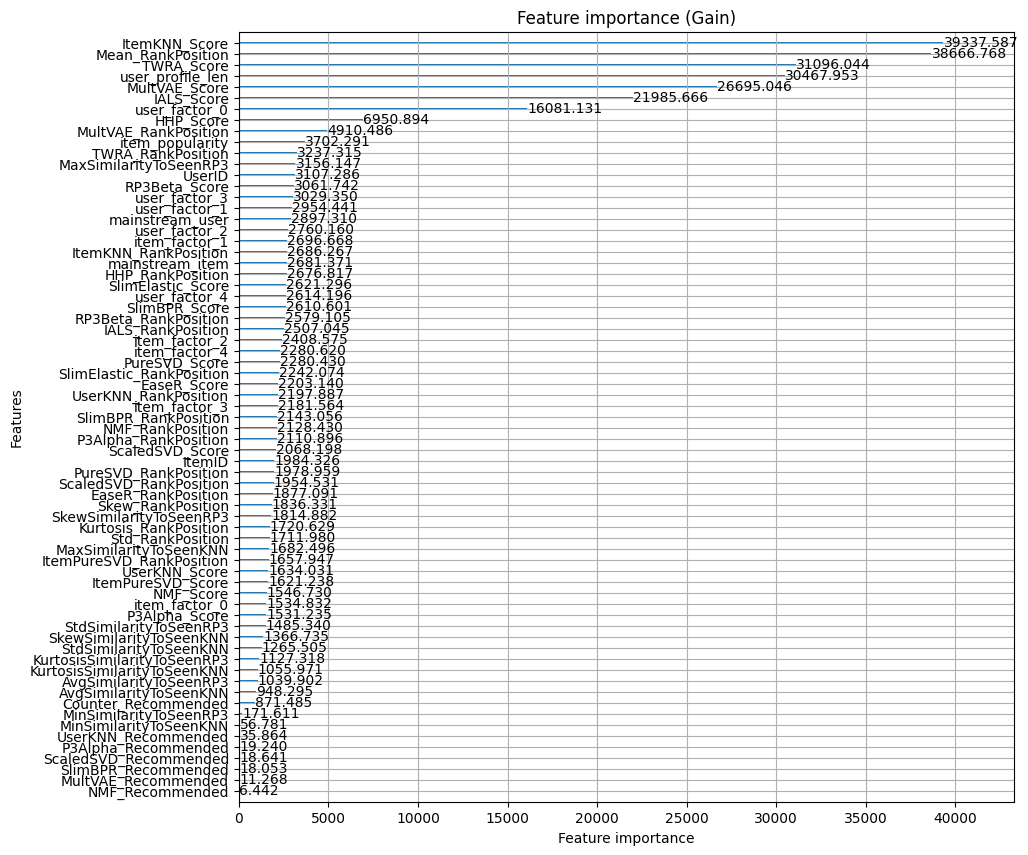

In [40]:
from lightgbm import plot_importance

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(LGBM_model, importance_type='gain', title='Feature importance (Gain)', ax=ax)

<Axes: title={'center': 'Feature importance (Split)'}, xlabel='Feature importance', ylabel='Features'>

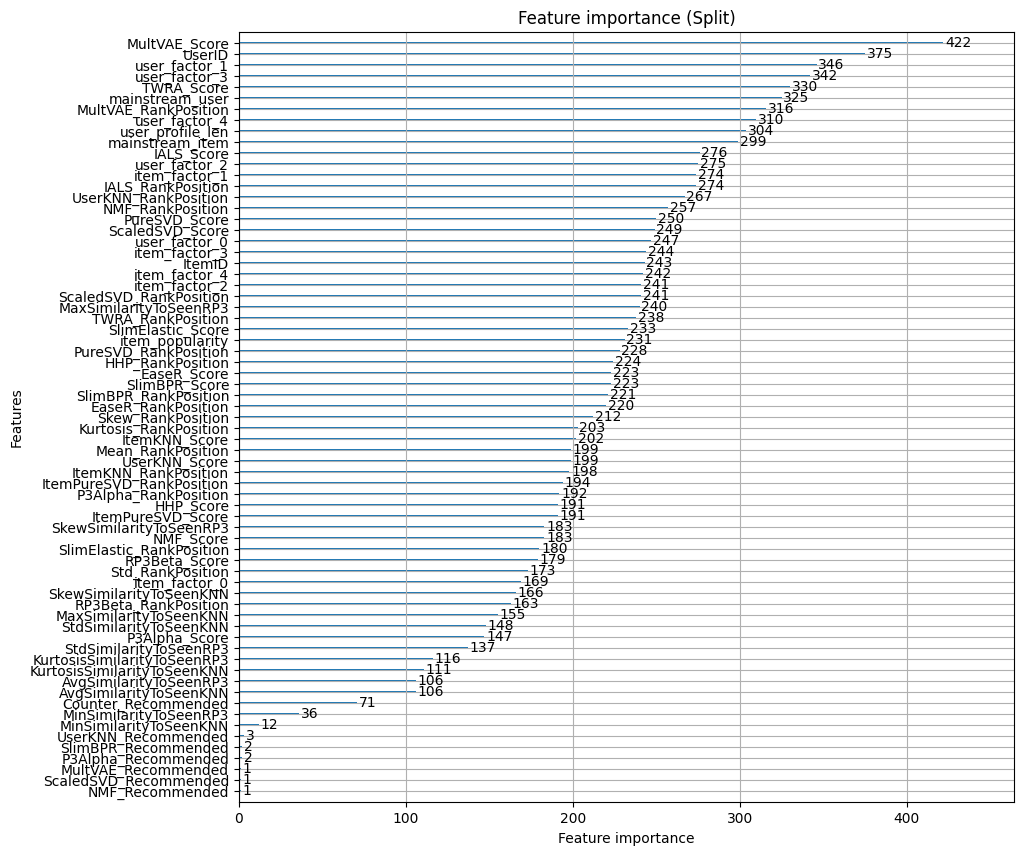

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(LGBM_model, importance_type='split', title='Feature importance (Split)', ax=ax)

In [42]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train_complete)
recommender_scaled_svd.fit(**params_scaled)

recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_train_complete)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train_complete)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_train_validation')

recommender_hhp = HHPRecommender(URM_train_complete)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_train_complete)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_train_complete)
# recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_train_validation.zip')

recommender_rp3_recall = RP3betaRecommender(URM_train_complete)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_train_complete)
recommender_item_recall.fit(**params_item_knn_recall)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 22347 (100.0%), 4203.81 column/sec. Elapsed time 5.32 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4667.88 column/sec. Elapsed time 2.79 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2648.57 column/sec. Elapsed time 8.44 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 2831.62 column/sec. Elapsed time 7.89 sec
PureSVDRecommender: URM Detected 627 ( 4.8%) users with no inter

In [43]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [44]:
cutoff = 50
n_users, n_items = URM_train_complete.shape

validation_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
validation_dataframe.index.name='UserID'

for user_id in tqdm.auto.tqdm(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    validation_dataframe.loc[user_id, "ItemID"] = recommendations
    
validation_dataframe = validation_dataframe.explode("ItemID")

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = validation_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        validation_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        validation_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        validation_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[validation_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        validation_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        validation_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[validation_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        validation_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        validation_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        validation_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        validation_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        validation_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()
    
validation_dataframe = validation_dataframe.reset_index()
validation_dataframe = validation_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in validation_dataframe.columns if col.endswith('_Recommended')]
validation_dataframe['Counter_Recommended'] = validation_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in validation_dataframe.columns if col.endswith('_RankPosition')]
validation_dataframe['Mean_RankPosition'] = validation_dataframe[position_columns].mean(axis=1)
validation_dataframe['Std_RankPosition'] = validation_dataframe[position_columns].std(axis=1)
validation_dataframe['Skew_RankPosition'] = validation_dataframe[position_columns].skew(axis=1)
validation_dataframe['Kurtosis_RankPosition'] = validation_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
item_popularity = item_popularity / np.max(item_popularity)
validation_dataframe['item_popularity'] = item_popularity[validation_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
user_popularity = user_popularity / np.max(user_popularity)
validation_dataframe['user_profile_len'] = user_popularity[validation_dataframe["UserID"].values.astype(int)]
validation_dataframe

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_20/626954395.py:52: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  validation_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
/tmp/ipykernel_20/626954395.py:53: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  validation_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)


  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,StdSimilarityToSeenRP3,SkewSimilarityToSeenRP3,KurtosisSimilarityToSeenRP3,Counter_Recommended,Mean_RankPosition,Std_RankPosition,Skew_RankPosition,Kurtosis_RankPosition,item_popularity,user_profile_len
0,0,0,0.000000,22303.0,0.0,0.005663,133.0,0.0,0.000000,22283.0,...,0.000000,NaN,NaN,0,9161.133333,11034.608795,0.438419,-2.085587,0.886121,0.032075
1,0,1,0.000000,7499.0,0.0,0.010246,60.0,0.0,0.000000,7477.0,...,0.000000,NaN,NaN,0,2885.733333,3500.712631,0.552869,-1.858036,1.000000,0.032075
2,0,2,0.000000,7500.0,0.0,0.010817,58.0,0.0,0.000000,7478.0,...,0.000000,NaN,NaN,1,6237.600000,6386.778987,0.997782,1.376678,0.811388,0.032075
3,0,3,0.000000,7501.0,0.0,0.012973,51.0,0.0,0.000000,7479.0,...,0.000000,NaN,NaN,0,4538.666667,5393.305780,1.002611,0.534822,0.973665,0.032075
4,0,7,0.189751,24.0,0.0,0.008546,73.0,0.0,0.113997,12.0,...,0.000000,NaN,NaN,1,1604.933333,4586.695721,3.231686,10.715886,0.692527,0.032075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055398,13023,10912,0.124691,41.0,0.0,0.077127,408.0,0.0,0.030217,154.0,...,0.011540,2.528026,4.419128,0,2355.066667,4825.602456,3.269872,11.517487,0.004982,0.056604
1055399,13023,11018,0.149842,36.0,0.0,0.163464,120.0,0.0,0.147351,30.0,...,0.011594,2.325696,3.618560,0,171.733333,255.100111,1.943374,2.761437,0.004982,0.056604
1055400,13023,11653,0.248895,16.0,0.0,0.164520,118.0,0.0,0.305779,12.0,...,0.013050,3.435117,10.790638,2,115.800000,167.459675,2.053184,4.202460,0.007117,0.056604
1055401,13023,11955,0.260745,15.0,0.0,0.157063,126.0,0.0,0.138857,32.0,...,0.014879,2.872438,6.805297,0,194.533333,377.837241,2.745526,7.327920,0.004982,0.056604


In [45]:
mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
validation_dataframe['mainstream_user'] = mainstream_user[validation_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
validation_dataframe['mainstream_item'] = mainstream_item[validation_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_train[:, :5].shape[1])])
validation_dataframe = validation_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
validation_dataframe = validation_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
validation_dataframe = validation_dataframe.sort_values(by='UserID')

validation_dataframe

,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,0.000000,22303.0,0.0,0.005663,133.0,0.0,0.000000,22283.0,...,0.163921,0.090707,-0.216788,-0.041741,0.056197,0.005684,-0.001896,0.008995,-0.013853,-0.002147
60,0,1257,0.113153,50.0,0.0,0.002463,460.0,0.0,0.055753,56.0,...,0.009264,0.007807,0.009192,0.015810,0.004970,0.005684,-0.001896,0.008995,-0.013853,-0.002147
59,0,1213,0.219015,17.0,0.0,0.004029,208.0,0.0,0.086829,25.0,...,0.007796,-0.009614,0.002953,-0.000483,-0.004862,0.005684,-0.001896,0.008995,-0.013853,-0.002147
58,0,1088,0.206087,20.0,0.0,0.000000,9783.0,0.0,0.063827,43.0,...,0.011467,-0.011217,0.021460,0.020043,0.052159,0.005684,-0.001896,0.008995,-0.013853,-0.002147
57,0,1082,0.261194,14.0,0.0,0.003559,265.0,0.0,0.101984,16.0,...,0.008902,-0.013901,0.005310,0.008307,0.003830,0.005684,-0.001896,0.008995,-0.013853,-0.002147
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055380,13023,2152,0.000000,5872.0,0.0,0.216950,65.0,0.0,0.000000,5857.0,...,0.004974,-0.014541,0.004915,0.004194,0.023232,0.006896,-0.007143,0.001571,0.006195,0.023549
1055379,13023,2119,0.487735,4.0,1.0,0.364687,11.0,0.0,0.439395,7.0,...,0.003394,-0.009902,0.004116,0.002884,0.015884,0.006896,-0.007143,0.001571,0.006195,0.023549
1055381,13023,2195,0.296294,11.0,0.0,0.290332,27.0,0.0,0.251844,15.0,...,0.004869,-0.011313,0.006562,-0.000144,0.018232,0.006896,-0.007143,0.001571,0.006195,0.023549
1055377,13023,1791,0.034666,147.0,0.0,0.248859,40.0,0.0,0.050318,88.0,...,0.006689,-0.014163,0.015855,0.009517,0.029980,0.006896,-0.007143,0.001571,0.006195,0.023549


In [46]:
# validation_dataframe["UserID"] = validation_dataframe["UserID"].astype("category")
# validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype("category")

validation_dataframe["UserID"] = validation_dataframe["UserID"].astype(int)
validation_dataframe["ItemID"] = validation_dataframe["ItemID"].astype(int)

# object_columns = validation_dataframe.select_dtypes(include=['object']).columns
# validation_dataframe[object_columns] = validation_dataframe[object_columns].astype('category')

In [47]:
class LightGBMRerankerRecommender:
    def __init__(self, URM_train, XGB_model, df):
        self.URM_train = URM_train
        self.df = df
        self.XGB_model = XGB_model
        
    def recommend(self, user_ids, cutoff=10, return_scores=True, remove_seen_flag=True, remove_top_pop_flag=True, remove_custom_items_flag=False):
        recommendations = []
        for user_id in user_ids:
            df_slice = self.df[self.df['UserID'] == user_id]
            items = df_slice.ItemID.to_numpy()
            preds = self.XGB_model.predict_proba(df_slice)[:, 1].flatten()
            recommendations.append(items[np.argsort(preds)[-cutoff:][::-1]].tolist())
            
        if return_scores:
            rec, scores = recommender_item.recommend(user_ids, cutoff=cutoff, return_scores=return_scores)
            # useless scores
            return np.array(recommendations), scores
        return np.array(recommendations)
    
    def get_URM_train(self):
        return self.URM_train

In [48]:
recommender = LightGBMRerankerRecommender(URM_train_complete, LGBM_model, validation_dataframe)
result_df, _ = evaluator.evaluateRecommender(recommender)
result_df

EvaluatorHoldout: Processed 10456 (100.0%) in 1.16 min. Users per second: 150


,PRECISION,PRECISION_RECALL_MIN_DEN,RECALL,MAP,MAP_MIN_DEN,MRR,NDCG,F1,HIT_RATE,ARHR_ALL_HITS,...,COVERAGE_USER,COVERAGE_USER_HIT,USERS_IN_GT,DIVERSITY_GINI,SHANNON_ENTROPY,RATIO_DIVERSITY_HERFINDAHL,RATIO_DIVERSITY_GINI,RATIO_SHANNON_ENTROPY,RATIO_AVERAGE_POPULARITY,RATIO_NOVELTY
cutoff,,,,,,,,,,,,,,,,,,,,,
10,0.098728,0.171763,0.145424,0.048909,0.083229,0.270276,0.152643,0.11761,0.537682,0.358967,...,0.802826,0.431665,0.802826,0.055414,10.099487,0.997034,0.159891,0.778025,2.041703,0.294085


In [49]:
def objective_xgboost(trial):

    LGBM_model = LGBMClassifier(
        objective = trial.suggest_categorical('objective', ["binary", "cross_entropy", "cross_entropy_lambda"]),
        n_estimators = trial.suggest_int('n_estimators', 10, 5000, log=True),
        learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.5, log=True),
        reg_alpha = trial.suggest_float('reg_alpha', 1e-5, 1, log=True),
        reg_lambda = trial.suggest_float('reg_lambda', 1e-5, 1, log=True),
        max_depth = trial.suggest_int('max_depth', 3, 20),
        num_leaves = trial.suggest_int('num_leaves', 8, 1024),
        boosting_type = "gbdt",
        min_split_gain = trial.suggest_float('min_split_gain', 1e-7, 10, log=True),
        min_child_weight = trial.suggest_float('min_child_weight', 1e-7, 1, log=True),
        min_child_samples = trial.suggest_int('min_child_samples', 5, 200),
        subsample = trial.suggest_float('subsample', 0.1, 0.9),
        subsample_freq = trial.suggest_int('subsample_freq', 1, 20),
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.1, 0.9)
    )
    
    LGBM_model.fit(
        X_train,
        y_train,
    )
    
    recommender = LightGBMRerankerRecommender(URM_train_complete, LGBM_model, validation_dataframe)
    result_df, _ = evaluator.evaluateRecommender(recommender)
        
    return result_df.loc[10, 'MAP']

In [50]:
try:
    shutil.copyfile(
        '/kaggle/working/Recsys_Challenge_2023/tuning_results/tuning_hybrid_lightgbm_classifier.db', 
        config['database_path']
    )
except FileNotFoundError:
    pass

In [51]:
if config['tune_parameters']:
    study = optuna.create_study(direction='maximize', study_name='lightgbm_classifier_tuning', 
                                storage=f'sqlite:///{config["database_path"]}', load_if_exists=True)
    study.optimize(objective_xgboost, n_trials=config['n_trials'])

[I 2023-12-28 21:49:42,940] A new study created in RDB with name: lightgbm_classifier_tuning


EvaluatorHoldout: Processed 10456 (100.0%) in 56.20 sec. Users per second: 186


[I 2023-12-28 21:50:57,680] Trial 0 finished with value: 0.04581753394420807 and parameters: {'objective': 'binary', 'n_estimators': 44, 'learning_rate': 0.01001781071797554, 'reg_alpha': 0.023025136507345008, 'reg_lambda': 0.0002377428951553649, 'max_depth': 11, 'num_leaves': 612, 'min_split_gain': 0.8683492362589004, 'min_child_weight': 0.007765262835246804, 'min_child_samples': 30, 'subsample': 0.1418375314706972, 'subsample_freq': 18, 'colsample_bytree': 0.8682369797106323}. Best is trial 0 with value: 0.04581753394420807.


EvaluatorHoldout: Processed 10456 (100.0%) in 54.01 sec. Users per second: 194


[I 2023-12-28 21:52:01,000] Trial 1 finished with value: 0.05016490873319552 and parameters: {'objective': 'cross_entropy', 'n_estimators': 57, 'learning_rate': 0.1688864073584037, 'reg_alpha': 0.015261796536141256, 'reg_lambda': 0.09005821764370649, 'max_depth': 3, 'num_leaves': 603, 'min_split_gain': 2.397548017331313e-07, 'min_child_weight': 1.4445740653788145e-06, 'min_child_samples': 12, 'subsample': 0.36076282466269216, 'subsample_freq': 5, 'colsample_bytree': 0.22233443581938125}. Best is trial 1 with value: 0.05016490873319552.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.88 min. Users per second: 93


[I 2023-12-28 21:55:42,740] Trial 2 finished with value: 0.0523547541625682 and parameters: {'objective': 'cross_entropy', 'n_estimators': 1366, 'learning_rate': 0.0048249018026915195, 'reg_alpha': 0.4020556730926843, 'reg_lambda': 0.00012402048846675475, 'max_depth': 5, 'num_leaves': 850, 'min_split_gain': 6.37105391761828e-06, 'min_child_weight': 0.02173634807728647, 'min_child_samples': 142, 'subsample': 0.26624730245779116, 'subsample_freq': 17, 'colsample_bytree': 0.2282434922530251}. Best is trial 2 with value: 0.0523547541625682.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.75 min. Users per second: 63


[I 2023-12-28 22:06:59,077] Trial 3 finished with value: 0.05260360118288604 and parameters: {'objective': 'cross_entropy_lambda', 'n_estimators': 3804, 'learning_rate': 0.005376464222064609, 'reg_alpha': 1.3940375310859765e-05, 'reg_lambda': 0.034509571629461444, 'max_depth': 4, 'num_leaves': 321, 'min_split_gain': 2.4963101732183043e-05, 'min_child_weight': 0.0927188882482291, 'min_child_samples': 55, 'subsample': 0.6832886578387686, 'subsample_freq': 11, 'colsample_bytree': 0.8036551542350104}. Best is trial 3 with value: 0.05260360118288604.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.95 min. Users per second: 89


[I 2023-12-28 22:13:37,752] Trial 4 finished with value: 0.0496685468053587 and parameters: {'objective': 'cross_entropy', 'n_estimators': 427, 'learning_rate': 0.009908752369214366, 'reg_alpha': 0.00022067681360617592, 'reg_lambda': 0.00014132082589388197, 'max_depth': 17, 'num_leaves': 995, 'min_split_gain': 9.285787029657003e-06, 'min_child_weight': 8.255356251199496e-06, 'min_child_samples': 59, 'subsample': 0.5890371117739924, 'subsample_freq': 20, 'colsample_bytree': 0.5132607673945334}. Best is trial 3 with value: 0.05260360118288604.


EvaluatorHoldout: Processed 9000 (86.1%) in 5.04 min. Users per second: 30
EvaluatorHoldout: Processed 10456 (100.0%) in 5.84 min. Users per second: 30


[I 2023-12-28 22:26:44,439] Trial 5 finished with value: 0.05175089338847037 and parameters: {'objective': 'binary', 'n_estimators': 3017, 'learning_rate': 0.0002794495083199486, 'reg_alpha': 0.00012040119933733078, 'reg_lambda': 1.809461997348169e-05, 'max_depth': 17, 'num_leaves': 194, 'min_split_gain': 1.212342602732928, 'min_child_weight': 8.184427063883957e-07, 'min_child_samples': 198, 'subsample': 0.18751831537928415, 'subsample_freq': 11, 'colsample_bytree': 0.13630643429849335}. Best is trial 3 with value: 0.05260360118288604.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.12 min. Users per second: 156


[I 2023-12-28 22:28:33,462] Trial 6 finished with value: 0.04454972689790074 and parameters: {'objective': 'cross_entropy', 'n_estimators': 318, 'learning_rate': 0.12427223096301875, 'reg_alpha': 0.006359748868883284, 'reg_lambda': 0.004813200347660698, 'max_depth': 6, 'num_leaves': 828, 'min_split_gain': 1.2227896938584302e-07, 'min_child_weight': 8.392561834952259e-07, 'min_child_samples': 95, 'subsample': 0.4511683845733099, 'subsample_freq': 3, 'colsample_bytree': 0.14957732037463087}. Best is trial 3 with value: 0.05260360118288604.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.31 min. Users per second: 133


[I 2023-12-28 22:30:33,560] Trial 7 finished with value: 0.050712779022601476 and parameters: {'objective': 'cross_entropy_lambda', 'n_estimators': 360, 'learning_rate': 0.0001615432280567255, 'reg_alpha': 0.16280210035917353, 'reg_lambda': 0.00013517899181349354, 'max_depth': 7, 'num_leaves': 941, 'min_split_gain': 0.0010376820766582534, 'min_child_weight': 0.00017032141556606818, 'min_child_samples': 8, 'subsample': 0.15875178625766725, 'subsample_freq': 18, 'colsample_bytree': 0.1582295745909768}. Best is trial 3 with value: 0.05260360118288604.


EvaluatorHoldout: Processed 10456 (100.0%) in 57.10 sec. Users per second: 183


[I 2023-12-28 22:31:36,802] Trial 8 finished with value: 0.04573131474599595 and parameters: {'objective': 'cross_entropy', 'n_estimators': 11, 'learning_rate': 0.00023458328590724112, 'reg_alpha': 0.01122694283034257, 'reg_lambda': 0.04370691074272436, 'max_depth': 3, 'num_leaves': 868, 'min_split_gain': 0.12633567300433235, 'min_child_weight': 0.05420953643817028, 'min_child_samples': 137, 'subsample': 0.2932187673248474, 'subsample_freq': 12, 'colsample_bytree': 0.47815440315961477}. Best is trial 3 with value: 0.05260360118288604.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.17 min. Users per second: 149


[I 2023-12-28 22:34:20,822] Trial 9 finished with value: 0.05110512609149807 and parameters: {'objective': 'binary', 'n_estimators': 106, 'learning_rate': 0.0002741299297292278, 'reg_alpha': 0.0007545874523184408, 'reg_lambda': 0.03147925845995844, 'max_depth': 18, 'num_leaves': 971, 'min_split_gain': 3.715598548275175e-06, 'min_child_weight': 0.045849483888618495, 'min_child_samples': 154, 'subsample': 0.4762083507280095, 'subsample_freq': 19, 'colsample_bytree': 0.8082119869847059}. Best is trial 3 with value: 0.05260360118288604.


EvaluatorHoldout: Processed 6000 (57.4%) in 5.35 min. Users per second: 19
EvaluatorHoldout: Processed 10456 (100.0%) in 9.38 min. Users per second: 19


[I 2023-12-28 23:04:37,388] Trial 10 finished with value: 0.05231866187561524 and parameters: {'objective': 'cross_entropy_lambda', 'n_estimators': 4288, 'learning_rate': 0.0025125715653442245, 'reg_alpha': 1.4347177110350393e-05, 'reg_lambda': 0.2377036981889415, 'max_depth': 11, 'num_leaves': 128, 'min_split_gain': 0.0007721895183999552, 'min_child_weight': 0.7373786963641317, 'min_child_samples': 69, 'subsample': 0.7995583940165267, 'subsample_freq': 7, 'colsample_bytree': 0.7714387066273599}. Best is trial 3 with value: 0.05260360118288604.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.75 min. Users per second: 63


[I 2023-12-28 23:14:22,741] Trial 11 finished with value: 0.0525030779016533 and parameters: {'objective': 'cross_entropy_lambda', 'n_estimators': 1456, 'learning_rate': 0.002820583587360183, 'reg_alpha': 0.9276604068872617, 'reg_lambda': 0.0037332530106215602, 'max_depth': 8, 'num_leaves': 399, 'min_split_gain': 4.55340324784873e-05, 'min_child_weight': 0.0024254805968734086, 'min_child_samples': 131, 'subsample': 0.6505284524102107, 'subsample_freq': 14, 'colsample_bytree': 0.6904887864161061}. Best is trial 3 with value: 0.05260360118288604.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.89 min. Users per second: 60


[I 2023-12-28 23:25:30,639] Trial 12 finished with value: 0.0521956900268401 and parameters: {'objective': 'cross_entropy_lambda', 'n_estimators': 1240, 'learning_rate': 0.001613659845028692, 'reg_alpha': 1.0035791451929615e-05, 'reg_lambda': 0.8699876076699383, 'max_depth': 9, 'num_leaves': 341, 'min_split_gain': 0.00019192655826298302, 'min_child_weight': 0.0010850716060520635, 'min_child_samples': 110, 'subsample': 0.676432340837215, 'subsample_freq': 15, 'colsample_bytree': 0.7055463379993668}. Best is trial 3 with value: 0.05260360118288604.


EvaluatorHoldout: Processed 4000 (38.3%) in 5.90 min. Users per second: 11
EvaluatorHoldout: Processed 8000 (76.5%) in 11.78 min. Users per second: 11
EvaluatorHoldout: Processed 10456 (100.0%) in 15.38 min. Users per second: 11


[I 2023-12-29 00:15:34,924] Trial 13 finished with value: 0.041842786400457174 and parameters: {'objective': 'cross_entropy_lambda', 'n_estimators': 4380, 'learning_rate': 0.03171510463348114, 'reg_alpha': 0.8726883837345221, 'reg_lambda': 0.0041986499816111834, 'max_depth': 14, 'num_leaves': 353, 'min_split_gain': 7.12232434534281e-05, 'min_child_weight': 0.998574140713478, 'min_child_samples': 55, 'subsample': 0.8447249822231613, 'subsample_freq': 8, 'colsample_bytree': 0.6737031334590793}. Best is trial 3 with value: 0.05260360118288604.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.57 min. Users per second: 111


[I 2023-12-29 00:20:57,343] Trial 14 finished with value: 0.05074498123656544 and parameters: {'objective': 'cross_entropy_lambda', 'n_estimators': 1332, 'learning_rate': 0.0009539136357471129, 'reg_alpha': 0.08297138217641563, 'reg_lambda': 0.012041175543054389, 'max_depth': 8, 'num_leaves': 12, 'min_split_gain': 0.014328666001038654, 'min_child_weight': 0.00048258948437547843, 'min_child_samples': 97, 'subsample': 0.6867119176512182, 'subsample_freq': 14, 'colsample_bytree': 0.8614785772780288}. Best is trial 3 with value: 0.05260360118288604.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.58 min. Users per second: 111


[I 2023-12-29 00:24:39,040] Trial 15 finished with value: 0.05249034882379396 and parameters: {'objective': 'cross_entropy_lambda', 'n_estimators': 939, 'learning_rate': 0.01910815858106789, 'reg_alpha': 0.0018857595982749002, 'reg_lambda': 0.0013395778018941683, 'max_depth': 5, 'num_leaves': 424, 'min_split_gain': 0.004211878766203533, 'min_child_weight': 0.0034754920128106303, 'min_child_samples': 174, 'subsample': 0.5687839542544721, 'subsample_freq': 9, 'colsample_bytree': 0.6392646027594521}. Best is trial 3 with value: 0.05260360118288604.


EvaluatorHoldout: Processed 9000 (86.1%) in 5.04 min. Users per second: 30
EvaluatorHoldout: Processed 10456 (100.0%) in 5.89 min. Users per second: 30


[I 2023-12-29 00:48:11,871] Trial 16 finished with value: 0.051882195686231994 and parameters: {'objective': 'cross_entropy_lambda', 'n_estimators': 2429, 'learning_rate': 0.0009079847919555107, 'reg_alpha': 0.04511621198658368, 'reg_lambda': 0.018591657310949732, 'max_depth': 9, 'num_leaves': 526, 'min_split_gain': 3.6697590244371857e-05, 'min_child_weight': 9.850412803669712e-05, 'min_child_samples': 114, 'subsample': 0.7608247560199135, 'subsample_freq': 13, 'colsample_bytree': 0.8929029011213518}. Best is trial 3 with value: 0.05260360118288604.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.72 min. Users per second: 101


[I 2023-12-29 00:54:01,697] Trial 17 finished with value: 0.051689342945798925 and parameters: {'objective': 'cross_entropy_lambda', 'n_estimators': 662, 'learning_rate': 0.004526644197929322, 'reg_alpha': 0.003620533786101199, 'reg_lambda': 0.0016277677261565613, 'max_depth': 14, 'num_leaves': 236, 'min_split_gain': 0.00022171779091601773, 'min_child_weight': 0.15118230328410856, 'min_child_samples': 80, 'subsample': 0.715229331451862, 'subsample_freq': 1, 'colsample_bytree': 0.7590147302065474}. Best is trial 3 with value: 0.05260360118288604.


EvaluatorHoldout: Processed 7000 (66.9%) in 5.56 min. Users per second: 21
EvaluatorHoldout: Processed 10456 (100.0%) in 8.38 min. Users per second: 21


[I 2023-12-29 01:25:07,921] Trial 18 finished with value: 0.051452583615696004 and parameters: {'objective': 'cross_entropy_lambda', 'n_estimators': 2328, 'learning_rate': 0.0024202246563171438, 'reg_alpha': 0.1905792665804366, 'reg_lambda': 0.10445921164795362, 'max_depth': 13, 'num_leaves': 704, 'min_split_gain': 1.0189726071248007e-06, 'min_child_weight': 0.0034113126614043923, 'min_child_samples': 38, 'subsample': 0.837931413301296, 'subsample_freq': 16, 'colsample_bytree': 0.6174297643130346}. Best is trial 3 with value: 0.05260360118288604.


EvaluatorHoldout: Processed 10456 (100.0%) in 2.38 min. Users per second: 73


[I 2023-12-29 01:33:51,845] Trial 19 finished with value: 0.017816507723977096 and parameters: {'objective': 'cross_entropy_lambda', 'n_estimators': 2194, 'learning_rate': 0.45371867579163555, 'reg_alpha': 0.042177926554484366, 'reg_lambda': 0.010530944841322646, 'max_depth': 5, 'num_leaves': 473, 'min_split_gain': 3.1268504724631514e-05, 'min_child_weight': 1.0778652347264535e-07, 'min_child_samples': 127, 'subsample': 0.8921296403403869, 'subsample_freq': 10, 'colsample_bytree': 0.7582539089071476}. Best is trial 3 with value: 0.05260360118288604.


EvaluatorHoldout: Processed 4000 (38.3%) in 5.95 min. Users per second: 11
EvaluatorHoldout: Processed 8000 (76.5%) in 12.00 min. Users per second: 11
EvaluatorHoldout: Processed 10456 (100.0%) in 15.67 min. Users per second: 11


[I 2023-12-29 02:19:51,457] Trial 20 finished with value: 0.04172753397456978 and parameters: {'objective': 'binary', 'n_estimators': 4760, 'learning_rate': 0.026228755449769495, 'reg_alpha': 0.9453748837982852, 'reg_lambda': 0.001391954156493805, 'max_depth': 20, 'num_leaves': 287, 'min_split_gain': 6.817149963219845e-07, 'min_child_weight': 0.15923330643842631, 'min_child_samples': 162, 'subsample': 0.6261440450176958, 'subsample_freq': 6, 'colsample_bytree': 0.585196026535249}. Best is trial 3 with value: 0.05260360118288604.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.13 min. Users per second: 154


[I 2023-12-29 02:22:07,329] Trial 21 finished with value: 0.05247383593835436 and parameters: {'objective': 'cross_entropy_lambda', 'n_estimators': 557, 'learning_rate': 0.016890549836945948, 'reg_alpha': 0.0014834261004711188, 'reg_lambda': 0.0009643208098281185, 'max_depth': 4, 'num_leaves': 431, 'min_split_gain': 0.0036793999940138546, 'min_child_weight': 0.004047928840098229, 'min_child_samples': 181, 'subsample': 0.5575292290915783, 'subsample_freq': 9, 'colsample_bytree': 0.6997505333917655}. Best is trial 3 with value: 0.05260360118288604.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.63 min. Users per second: 107


[I 2023-12-29 02:26:12,869] Trial 22 finished with value: 0.05270805248903996 and parameters: {'objective': 'cross_entropy_lambda', 'n_estimators': 721, 'learning_rate': 0.006537623924734671, 'reg_alpha': 0.00227442628555843, 'reg_lambda': 0.00429207245155583, 'max_depth': 7, 'num_leaves': 410, 'min_split_gain': 0.006791510108238098, 'min_child_weight': 0.0011887180518276416, 'min_child_samples': 170, 'subsample': 0.5549743807637126, 'subsample_freq': 11, 'colsample_bytree': 0.640587184373087}. Best is trial 22 with value: 0.05270805248903996.


EvaluatorHoldout: Processed 10456 (100.0%) in 1.81 min. Users per second: 97


[I 2023-12-29 02:31:27,542] Trial 23 finished with value: 0.05243230893479586 and parameters: {'objective': 'cross_entropy_lambda', 'n_estimators': 815, 'learning_rate': 0.005827709995838561, 'reg_alpha': 0.006190417137368498, 'reg_lambda': 0.006794450623358457, 'max_depth': 7, 'num_leaves': 121, 'min_split_gain': 0.03482278865465254, 'min_child_weight': 0.0009007874153640922, 'min_child_samples': 200, 'subsample': 0.6483928689463742, 'subsample_freq': 12, 'colsample_bytree': 0.8226042928879977}. Best is trial 22 with value: 0.05270805248903996.


EvaluatorHoldout: Processed 10456 (100.0%) in 3.11 min. Users per second: 56


[I 2023-12-29 02:43:27,932] Trial 24 finished with value: 0.05218713945665009 and parameters: {'objective': 'cross_entropy_lambda', 'n_estimators': 1552, 'learning_rate': 0.0034827661993282215, 'reg_alpha': 5.124850500021683e-05, 'reg_lambda': 0.01819155259978069, 'max_depth': 9, 'num_leaves': 372, 'min_split_gain': 0.00043771831775545896, 'min_child_weight': 5.167587660491593e-05, 'min_child_samples': 154, 'subsample': 0.727332975386388, 'subsample_freq': 14, 'colsample_bytree': 0.5783434929740642}. Best is trial 22 with value: 0.05270805248903996.


In [52]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

In [53]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

In [54]:
if config['tune_parameters']:
    fig = optuna.visualization.plot_slice(study)
    fig.show()

In [55]:
if config['tune_parameters']:
    with open('/kaggle/working/best_params_lightgbm_classifier.json', 'w') as params_file:
        json.dump(study.best_params, params_file)
        
    if config['save_github']: 
        upload_file(
            '/kaggle/working/best_params_lightgbm_classifier.json', 
            'tuning_results/best_params_lightgbm_classifier.json', 
            'Lightgbm tuning results (from kaggle notebook)'
        )
    
elif config['copy_prev_best_params']:
    shutil.copyfile(
        '/kaggle/input/lightgbm/best_params_lightgbm_classifier.json', 
        '/kaggle/working/best_params_lightgbm_classifier.json'
    )

In [56]:
if config['save_github'] and config['tune_parameters']:
    upload_file(
        config['database_path'],
        'tuning_results/tuning_hybrid_lightgbm_classifier.db', 
        'Xgboost tuning db updated results (from kaggle notebook)'
    )

In [57]:
with open('/kaggle/working/best_params_lightgbm_classifier.json', 'r') as params_file:
    lgbm_params = json.load(params_file)
lgbm_params['boosting_type'] = 'gbdt'
lgbm_params

{'objective': 'cross_entropy_lambda',
 'n_estimators': 721,
 'learning_rate': 0.006537623924734671,
 'reg_alpha': 0.00227442628555843,
 'reg_lambda': 0.00429207245155583,
 'max_depth': 7,
 'num_leaves': 410,
 'min_split_gain': 0.006791510108238098,
 'min_child_weight': 0.0011887180518276416,
 'min_child_samples': 170,
 'subsample': 0.5549743807637126,
 'subsample_freq': 11,
 'colsample_bytree': 0.640587184373087,
 'boosting_type': 'gbdt'}

In [58]:
recommender_item = ItemKNNCFRecommender(URM_train_complete)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_train_complete)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_train_complete)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_train_complete)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_train_complete)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])
user_factors_final_train = recommender_pure_svd.USER_factors
item_factors_final_train = recommender_pure_svd.ITEM_factors

recommender_pure_svd_item = PureSVDItemRecommender(URM_train_complete)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_scaled_svd = ScaledPureSVDRecommender(URM_train_complete)
recommender_scaled_svd.fit(**params_scaled)

recommender_nmf = NMFRecommender(URM_train_complete)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_train_validation.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_train_complete)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_train_validation.zip')

recommender_slim = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_train_validation.zip')

recommender_ease_r = EASE_R_Recommender(URM_train_complete)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_train_validation.zip')

recommender_ials = IALSRecommender(URM_train_complete)
recommender_ials.load_model('/kaggle/working/', 'ials_train_validation.zip')

recommender_vae = MultVAERecommender(URM_train_complete)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_train_validation')

recommender_hhp = HHPRecommender(URM_train_complete)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_train_complete)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_train_complete)
# recommender_als.load_model('/kaggle/working/', 'als_train_validation.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_train_complete)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_train_validation.zip')

recommender_rp3_recall = RP3betaRecommender(URM_train_complete)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_train_complete)
recommender_item_recall.fit(**params_item_knn_recall)

ItemKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 22347 (100.0%), 4509.57 column/sec. Elapsed time 4.96 sec
UserKNNCFRecommender: URM Detected 627 ( 4.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 247 ( 1.1%) items with no interactions.
Similarity column 13024 (100.0%), 4803.76 column/sec. Elapsed time 2.71 sec
RP3betaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
RP3betaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2648.61 column/sec. Elapsed time 8.44 sec
P3alphaRecommender: URM Detected 627 ( 4.8%) users with no interactions.
P3alphaRecommender: URM Detected 247 ( 1.1%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 2964.37 column/sec. Elapsed time 7.54 sec
PureSVDRecommender: URM Detected 627 ( 4.8%) users with no inter

In [59]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [60]:
cutoff = 50
n_users, n_items = URM_train_complete.shape

final_train_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
final_train_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    final_train_dataframe.loc[user_id, "ItemID"] = recommendations
    
final_train_dataframe = final_train_dataframe.explode("ItemID")

URM_test_complete_coo = sps.coo_matrix(URM_test_complete)

correct_recommendations = pd.DataFrame({"UserID": URM_test_complete_coo.row,
                                        "ItemID": URM_test_complete_coo.col})
final_train_dataframe = pd.merge(final_train_dataframe, correct_recommendations, on=['UserID','ItemID'], how='left', indicator='Exist')
final_train_dataframe["Label"] = final_train_dataframe["Exist"] == "both"
final_train_dataframe.drop(columns = ['Exist'], inplace=True)

final_train_dataframe = final_train_dataframe.set_index('UserID')

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = final_train_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        final_train_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        final_train_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        final_train_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[final_train_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[final_train_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        final_train_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        final_train_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        final_train_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        final_train_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        final_train_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

final_train_dataframe = final_train_dataframe.reset_index()
final_train_dataframe = final_train_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in final_train_dataframe.columns if col.endswith('_Recommended')]
final_train_dataframe['Counter_Recommended'] = final_train_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in final_train_dataframe.columns if col.endswith('_RankPosition')]
final_train_dataframe['Mean_RankPosition'] = final_train_dataframe[position_columns].mean(axis=1)
final_train_dataframe['Std_RankPosition'] = final_train_dataframe[position_columns].std(axis=1)
final_train_dataframe['Skew_RankPosition'] = final_train_dataframe[position_columns].skew(axis=1)
final_train_dataframe['Kurtosis_RankPosition'] = final_train_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_train_complete).indptr)
item_popularity = item_popularity / np.max(item_popularity)
final_train_dataframe['item_popularity'] = item_popularity[final_train_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_train_complete).indptr)
user_popularity = user_popularity / np.max(user_popularity)
final_train_dataframe['user_profile_len'] = user_popularity[final_train_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_train_complete.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
final_train_dataframe['mainstream_user'] = mainstream_user[final_train_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_train_complete.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
final_train_dataframe['mainstream_item'] = mainstream_item[final_train_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_final_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_final_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_final_train[:, :5].shape[1])])

final_train_dataframe = final_train_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
final_train_dataframe = final_train_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
final_train_dataframe = final_train_dataframe.sort_values(by='UserID')
final_train_dataframe

/tmp/ipykernel_20/4000761057.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_20/4000761057.py:62: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/tmp/ipykernel_20/4000761057.py:63: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



  0%|          | 0/13024 [00:00<?, ?it/s]

,UserID,ItemID,Label,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,False,0.000000,22303.0,0.0,0.005663,133.0,0.0,0.000000,...,0.161283,0.057150,-0.179319,-0.017929,0.058489,0.005573,0.000276,0.007794,-0.010626,-0.001530
60,0,1257,False,0.113153,50.0,0.0,0.002463,460.0,0.0,0.055753,...,0.010722,0.007699,0.003787,0.018315,0.003574,0.005573,0.000276,0.007794,-0.010626,-0.001530
59,0,1213,False,0.219015,17.0,0.0,0.004029,208.0,0.0,0.086829,...,0.007025,-0.009459,0.005387,-0.001226,-0.007530,0.005573,0.000276,0.007794,-0.010626,-0.001530
58,0,1088,False,0.206087,20.0,0.0,0.000000,9783.0,0.0,0.063827,...,0.011559,-0.010351,0.023728,0.026254,0.054192,0.005573,0.000276,0.007794,-0.010626,-0.001530
57,0,1082,False,0.261194,14.0,0.0,0.003559,265.0,0.0,0.101984,...,0.009403,-0.015196,0.006102,0.006966,-0.003834,0.005573,0.000276,0.007794,-0.010626,-0.001530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1055380,13023,2152,False,0.000000,5872.0,0.0,0.216950,65.0,0.0,0.000000,...,0.005849,-0.017149,0.009934,0.010005,0.026216,0.009693,-0.007923,-0.000422,0.004503,0.023066
1055379,13023,2119,False,0.487735,4.0,1.0,0.364687,11.0,0.0,0.439395,...,0.004605,-0.013688,0.006540,0.004982,0.021528,0.009693,-0.007923,-0.000422,0.004503,0.023066
1055381,13023,2195,False,0.296294,11.0,0.0,0.290332,27.0,0.0,0.251844,...,0.005514,-0.016249,0.010045,0.002411,0.021653,0.009693,-0.007923,-0.000422,0.004503,0.023066
1055377,13023,1791,False,0.034666,147.0,0.0,0.248859,40.0,0.0,0.050318,...,0.006444,-0.013939,0.017594,0.011301,0.028735,0.009693,-0.007923,-0.000422,0.004503,0.023066


In [61]:
LGBM_model = LGBMClassifier(**lgbm_params)

y_train = final_train_dataframe["Label"].astype(int)
X_train = final_train_dataframe.drop(columns=["Label"])
X_train["UserID"] = X_train["UserID"].astype(int)
X_train["ItemID"] = X_train["ItemID"].astype(int)

LGBM_model.fit(
    X_train,
    y_train
)

LGBMClassifier(colsample_bytree=0.640587184373087,
               learning_rate=0.006537623924734671, max_depth=7,
               min_child_samples=170, min_child_weight=0.0011887180518276416,
               min_split_gain=0.006791510108238098, n_estimators=721,
               num_leaves=410, objective='cross_entropy_lambda',
               reg_alpha=0.00227442628555843, reg_lambda=0.00429207245155583,
               subsample=0.5549743807637126, subsample_freq=11)

<Axes: title={'center': 'Feature importance (Gain)'}, xlabel='Feature importance', ylabel='Features'>

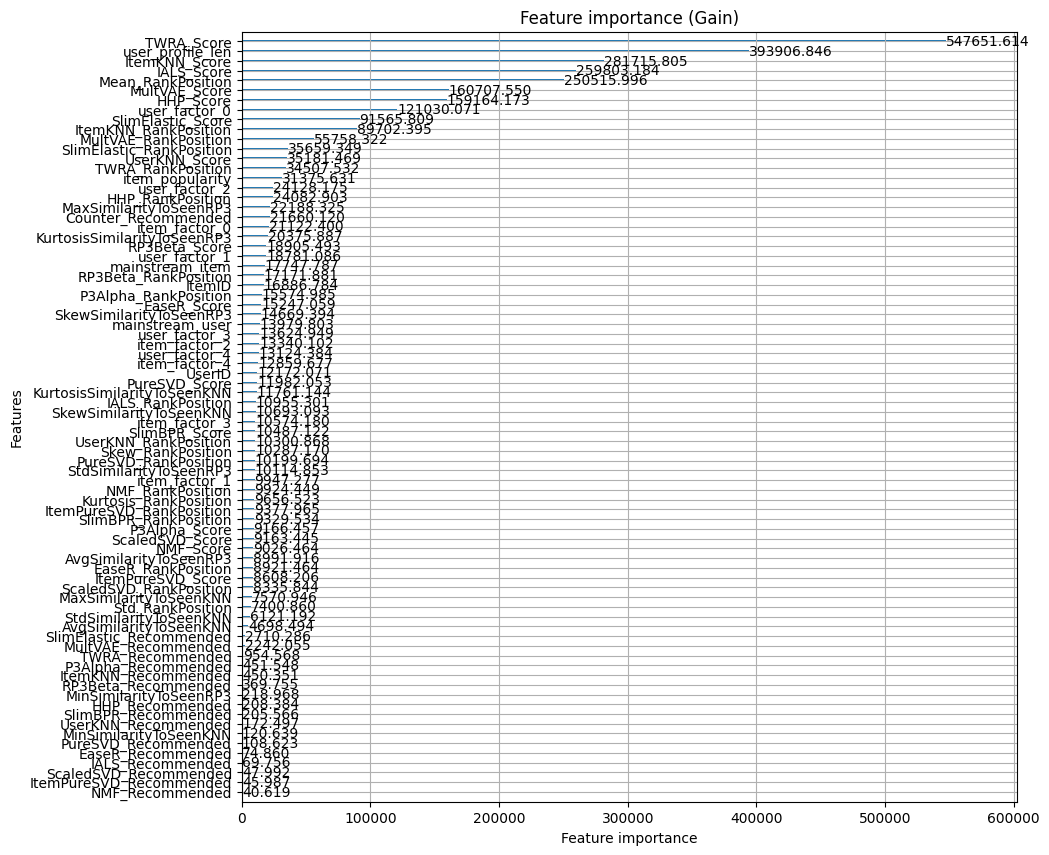

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(LGBM_model, importance_type='gain', title='Feature importance (Gain)', ax=ax)

<Axes: title={'center': 'Feature importance (Split)'}, xlabel='Feature importance', ylabel='Features'>

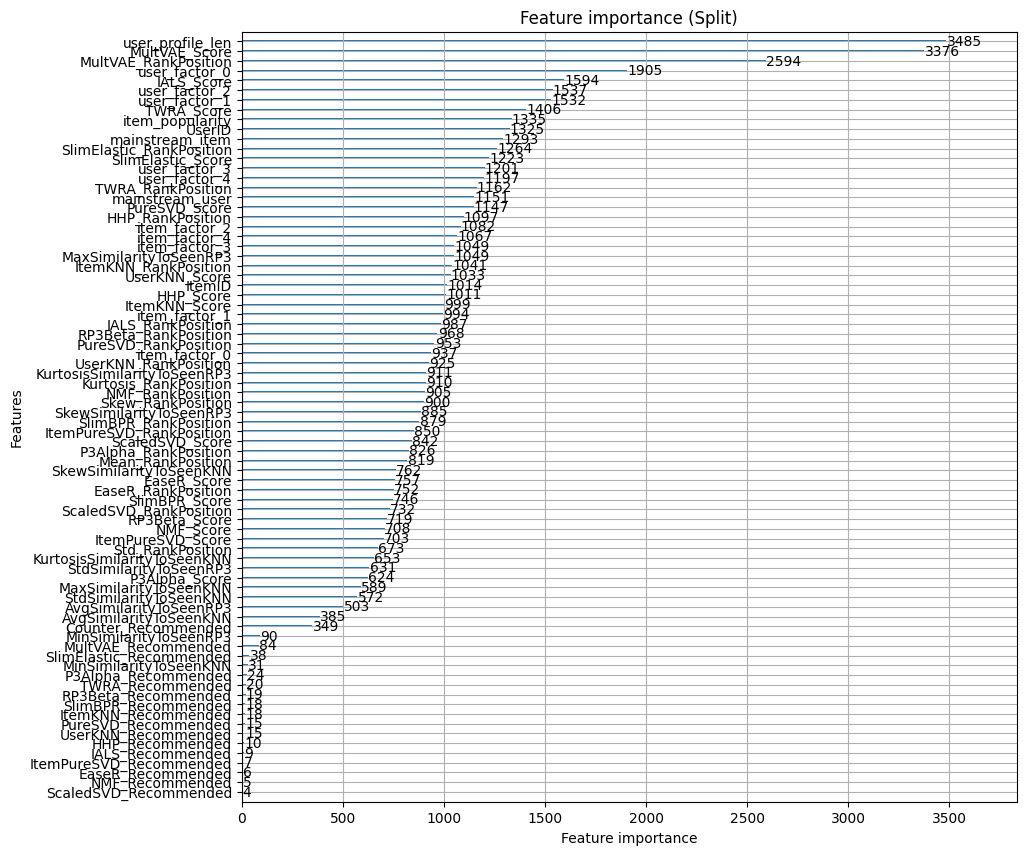

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(LGBM_model, importance_type='split', title='Feature importance (Split)', ax=ax)

In [64]:
recommender_item = ItemKNNCFRecommender(URM_all)
recommender_item.fit(**params_item_knn)

recommender_user = UserKNNCFRecommender(URM_all)
recommender_user.fit(**params_user_knn)

recommender_rp3 = RP3betaRecommender(URM_all)
recommender_rp3.fit(**params_rp3)

recommender_p3a = P3alphaRecommender(URM_all)
recommender_p3a.fit(**params_p3alpha)

recommender_pure_svd = PureSVDRecommender(URM_all)
recommender_pure_svd.fit(num_factors=params_pure_svd['factors'])

recommender_pure_svd_item = PureSVDItemRecommender(URM_all)
recommender_pure_svd_item.fit(**params_pure_svd_item)

recommender_nmf = NMFRecommender(URM_all)
recommender_nmf.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'nmf_all.zip')

recommender_slim_bpr = SLIM_BPR_Python(URM_all)
recommender_slim_bpr.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_bpr_all.zip')

recommender_slim = SLIMElasticNetRecommender(URM_all)
recommender_slim.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'slim_elastic_all.zip')

recommender_ease_r = EASE_R_Recommender(URM_all)
recommender_ease_r.load_model('/kaggle/working/Recsys_Challenge_2023/models/', 'ease_r_all.zip')

recommender_ials = IALSRecommender(URM_all)
recommender_ials.load_model('/kaggle/working/', 'ials_all.zip')

recommender_vae = MultVAERecommender(URM_all)
recommender_vae.load_model('/kaggle/working/', 'mult_vae_2_all')

recommender_hhp = HHPRecommender(URM_all)
recommender_hhp.fit(**params_hhp)

recommender_twra = TwoWayRankAggregationRecommender(URM_all)
recommender_twra.fit(**params_twra)

# recommender_als = ALSImplicitRecommender(URM_all)
# recommender_als.load_model('/kaggle/working/', 'als_all.npz')

########################## CANDIDATE GENERATORS ##########################

recommender_slim_recall = SLIMElasticNetRecommender(URM_all)
recommender_slim_recall.load_model('/kaggle/working/', 'slim_recall_all.zip')

recommender_rp3_recall = RP3betaRecommender(URM_all)
recommender_rp3_recall.fit(**params_rp3_recall)

recommender_item_recall = ItemKNNCFRecommender(URM_all)
recommender_item_recall.fit(**params_item_knn_recall)

ItemKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
ItemKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Similarity column 22347 (100.0%), 4207.38 column/sec. Elapsed time 5.31 sec
UserKNNCFRecommender: URM Detected 386 ( 3.0%) users with no interactions.
UserKNNCFRecommender: URM Detected 125 ( 0.6%) items with no interactions.
Similarity column 13024 (100.0%), 4122.48 column/sec. Elapsed time 3.16 sec
RP3betaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
RP3betaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
RP3betaRecommender: Similarity column 22347 (100.0%), 2543.55 column/sec. Elapsed time 8.79 sec
P3alphaRecommender: URM Detected 386 ( 3.0%) users with no interactions.
P3alphaRecommender: URM Detected 125 ( 0.6%) items with no interactions.
P3alphaRecommender: Similarity column 22347 (100.0%), 2682.34 column/sec. Elapsed time 8.33 sec
PureSVDRecommender: URM Detected 386 ( 3.0%) users with no inter

In [65]:
recommender_object_dict = {
    'ItemKNN': recommender_item,
    'UserKNN': recommender_user,
    'P3Alpha': recommender_p3a,
    'RP3Beta': recommender_rp3,
    'NMF': recommender_nmf,
    'PureSVD': recommender_pure_svd,
    'ScaledSVD': recommender_scaled_svd,
    'ItemPureSVD': recommender_pure_svd_item,
    'SlimElastic': recommender_slim,
    'SlimBPR': recommender_slim_bpr,
    'EaseR': recommender_ease_r,
    'IALS': recommender_ials,
    'MultVAE': recommender_vae,
    'HHP': recommender_hhp,
    'TWRA': recommender_twra,
    # 'ALS': recommender_als
}

In [66]:
cutoff = 50
n_users, n_items = URM_all.shape

prediction_dataframe = pd.DataFrame(index=range(0, n_users), columns = ["ItemID"])
prediction_dataframe.index.name='UserID'

for user_id in tqdm.tqdm_notebook(range(n_users)):    
    recommendations_slim = recommender_slim_recall.recommend(user_id, cutoff = cutoff)
    recommendations_knn = recommender_item_recall.recommend(user_id, cutoff = cutoff)
    recommendations_rp3 = recommender_rp3_recall.recommend(user_id, cutoff = cutoff)
    recommendations = np.union1d(recommendations_slim, np.union1d(recommendations_knn, recommendations_rp3))
    prediction_dataframe.loc[user_id, "ItemID"] = recommendations
    
prediction_dataframe = prediction_dataframe.explode("ItemID")

for label, recommender in tqdm.auto.tqdm(recommender_object_dict.items()):
    scores = recommender._compute_item_score(np.arange(n_users))
    linf_scores = scores / (LA.norm(scores, np.inf, axis=1, keepdims=True) + 1e-6)
    
    for user_id in tqdm.auto.tqdm(range(n_users)):
        item_list = prediction_dataframe.loc[user_id, "ItemID"].values.tolist()
        linf_scores[user_id, :] = recommender._remove_seen_on_scores(user_id, linf_scores[user_id, :])
        prediction_dataframe.loc[user_id, f"{label}_Score"] = linf_scores[user_id, item_list]
        
        rank = np.argsort(linf_scores[user_id, :])[::-1]
        positions = np.zeros(n_items, dtype=int)
        positions[rank] = np.arange(n_items)
        prediction_dataframe.loc[user_id, f"{label}_RankPosition"] = positions[item_list]
        
        recommended = np.isin(item_list, rank[:10], assume_unique=True)
        prediction_dataframe.loc[user_id, f"{label}_Recommended"] = recommended.astype(int)
    
    del scores, linf_scores, rank, positions, recommended
    gc.collect()
    
item_item_S = recommender_item.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = 0
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = 0
    else:
        similarities = item_item_S[prediction_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenKNN"] = similarities.mean(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenKNN"] = similarities.max(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenKNN"] = similarities.min(axis=1).flatten()
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenKNN"] = similarities.std(axis=1).flatten()
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenKNN"] = stats.skew(similarities, axis=1)
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenKNN"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

item_item_S = recommender_rp3.W_sparse.toarray()
for user_id in tqdm.auto.tqdm(range(n_users)):    
    seen_items = URM_train[user_id].nonzero()[1] # check if 0 or 1
    if len(seen_items) == 0:
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = 0
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = 0
    else:
        similarities = item_item_S[prediction_dataframe.loc[user_id, "ItemID"].values.astype(int), :][:, seen_items]
        prediction_dataframe.loc[user_id, "AvgSimilarityToSeenRP3"] = similarities.mean(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MaxSimilarityToSeenRP3"] = similarities.max(axis=1).flatten()
        prediction_dataframe.loc[user_id, "MinSimilarityToSeenRP3"] = similarities.min(axis=1).flatten()
        prediction_dataframe.loc[user_id, "StdSimilarityToSeenRP3"] = similarities.std(axis=1).flatten()
        prediction_dataframe.loc[user_id, "SkewSimilarityToSeenRP3"] = stats.skew(similarities, axis=1)
        prediction_dataframe.loc[user_id, "KurtosisSimilarityToSeenRP3"] = stats.kurtosis(similarities, axis=1)

del item_item_S
gc.collect()

prediction_dataframe = prediction_dataframe.reset_index()
prediction_dataframe = prediction_dataframe.rename(columns = {"index": "UserID"})

recommended_columns = [col for col in prediction_dataframe.columns if col.endswith('_Recommended')]
prediction_dataframe['Counter_Recommended'] = prediction_dataframe[recommended_columns].sum(axis=1).astype(int)

position_columns = [col for col in prediction_dataframe.columns if col.endswith('_RankPosition')]
prediction_dataframe['Mean_RankPosition'] = prediction_dataframe[position_columns].mean(axis=1)
prediction_dataframe['Std_RankPosition'] = prediction_dataframe[position_columns].std(axis=1)
prediction_dataframe['Skew_RankPosition'] = prediction_dataframe[position_columns].skew(axis=1)
prediction_dataframe['Kurtosis_RankPosition'] = prediction_dataframe[position_columns].kurtosis(axis=1)

item_popularity = np.ediff1d(sps.csc_matrix(URM_all).indptr)
item_popularity = item_popularity / np.max(item_popularity)
prediction_dataframe['item_popularity'] = item_popularity[prediction_dataframe["ItemID"].values.astype(int)]

user_popularity = np.ediff1d(sps.csr_matrix(URM_all).indptr)
user_popularity = user_popularity / np.max(user_popularity)
prediction_dataframe['user_profile_len'] = user_popularity[prediction_dataframe["UserID"].values.astype(int)]

mainstream_user = URM_all.dot(item_popularity) / np.where(user_popularity == 0, 1, user_popularity)
prediction_dataframe['mainstream_user'] = mainstream_user[prediction_dataframe["UserID"].values.astype(int)]

mainstream_item = URM_all.T.dot(user_popularity) / np.where(item_popularity == 0, 1, item_popularity)
prediction_dataframe['mainstream_item'] = mainstream_item[prediction_dataframe["ItemID"].values.astype(int)]

user_factors_df = pd.DataFrame(user_factors_final_train[:, :5], columns=[f'user_factor_{i}' for i in range(user_factors_final_train[:, :5].shape[1])])
item_factors_df = pd.DataFrame(item_factors_final_train[:, :5], columns=[f'item_factor_{i}' for i in range(item_factors_final_train[:, :5].shape[1])])

prediction_dataframe = prediction_dataframe.merge(item_factors_df, left_on='ItemID', right_index=True)
prediction_dataframe = prediction_dataframe.merge(user_factors_df, left_on='UserID', right_index=True)
prediction_dataframe = prediction_dataframe.sort_values(by='UserID')

prediction_dataframe["UserID"] = prediction_dataframe["UserID"].astype(int)
prediction_dataframe["ItemID"] = prediction_dataframe["ItemID"].astype(int)
prediction_dataframe

/tmp/ipykernel_20/3716254121.py:7: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

  0%|          | 0/13024 [00:00<?, ?it/s]

/tmp/ipykernel_20/3716254121.py:74: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/tmp/ipykernel_20/3716254121.py:75: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



,UserID,ItemID,ItemKNN_Score,ItemKNN_RankPosition,ItemKNN_Recommended,UserKNN_Score,UserKNN_RankPosition,UserKNN_Recommended,P3Alpha_Score,P3Alpha_RankPosition,...,item_factor_0,item_factor_1,item_factor_2,item_factor_3,item_factor_4,user_factor_0,user_factor_1,user_factor_2,user_factor_3,user_factor_4
0,0,0,0.000000,22150.0,0.0,0.049910,120.0,0.0,0.000000,22150.0,...,0.161283,0.057150,-0.179319,-0.017929,0.058489,0.005573,0.000276,0.007794,-0.010626,-0.001530
51,0,1067,0.000000,8330.0,0.0,0.055061,102.0,0.0,0.028730,174.0,...,0.006633,0.003640,0.012813,-0.006771,0.000972,0.005573,0.000276,0.007794,-0.010626,-0.001530
50,0,1056,0.148159,35.0,0.0,0.004526,4326.0,0.0,0.084663,23.0,...,0.002581,-0.001164,0.000103,-0.001671,0.001920,0.005573,0.000276,0.007794,-0.010626,-0.001530
49,0,976,0.166684,27.0,0.0,0.174678,9.0,1.0,0.044922,63.0,...,0.007626,-0.001412,0.009353,-0.007804,0.000635,0.005573,0.000276,0.007794,-0.010626,-0.001530
48,0,921,0.159207,31.0,0.0,0.106853,16.0,0.0,0.035512,102.0,...,0.008975,-0.001250,0.012296,-0.008343,0.003286,0.005573,0.000276,0.007794,-0.010626,-0.001530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1060085,13023,440,0.000000,7149.0,0.0,0.384692,27.0,0.0,0.000000,7177.0,...,0.017581,-0.029270,0.021202,0.014549,0.051794,0.009693,-0.007923,-0.000422,0.004503,0.023066
1060081,13023,346,0.087640,62.0,0.0,0.520535,7.0,1.0,0.076672,60.0,...,0.024040,-0.046680,0.024238,0.026045,0.079139,0.009693,-0.007923,-0.000422,0.004503,0.023066
1060080,13023,334,0.299805,21.0,0.0,0.400558,25.0,0.0,0.067050,72.0,...,0.023503,-0.038707,0.037088,0.024652,0.048741,0.009693,-0.007923,-0.000422,0.004503,0.023066
1060106,13023,3608,0.436101,10.0,0.0,0.359568,31.0,0.0,0.314715,18.0,...,0.003459,-0.010568,0.004390,0.002426,0.012327,0.009693,-0.007923,-0.000422,0.004503,0.023066


In [67]:
recommender = LightGBMRerankerRecommender(URM_all, LGBM_model, prediction_dataframe)

In [68]:
recommendations = recommender.recommend(user_ids_test['user_id'].unique() - 1, cutoff=10, return_scores=False)
recommendations = [' '.join([str(item + 1) for item in r]).strip() for r in recommendations]

submission_df = pd.DataFrame({'user_id': user_ids_test['user_id'].unique(), 'item_list': recommendations})
display(submission_df.head())

submission_df.to_csv('/kaggle/working/submission_lightgbm.csv', index=False)

,user_id,item_list
0,1,101 36 506 403 515 123 1546 694 977 637
1,2,1095 1522 12 47 196 3176 8 359 3 949
2,3,59 857 259 239 956 584 536 648 414 4252
3,4,249 28 50 7 5 146 2 314 139 3
4,5,1570 5138 77 131 471 170 7033 1220 1511 8664
